# Vascular segmentation - python notebook

Perform vascular segmentation using a multi-scale hessian-based method based on:

> M. Bernier, S. C. Cunnane, K. Whittingstall. *The morphology of the human cerebrovascular system*, Human Brain Mapping 2018 (https://doi.org/10.1002/hbm.24337)



## License and paper to cite

-----
-----
@**Author**: Michaël Bernier michael.bernier@usherbrooke.ca

@**Paper to cite**: M. Bernier, S. C. Cunnane, K. Whittingstall. The morphology of the human cerebrovascular system, Human Brain Mapping 2018 (https://doi.org/10.1002/hbm.24337)

@**License**: *Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)*

You are free to:

>     Share — copy and redistribute the material in any medium or format
    Adapt — remix, transform, and build upon the material

Under the following terms:

>     Attribution — You must give appropriate credit, provide a link to the license, and indicate if changes were made.
    NonCommercial — You may not use the material for commercial purposes.

-----
-----

## Data preparation

### Import packages and install some missing ones

In [ ]:
import pip
import os
import sys   
from time import perf_counter
import warnings
warnings.filterwarnings("ignore")
import subprocess

#### Should comment these as soon as it is installed

#!pip install numpy
#!pip install matplotlib
#!pip install scikit-learn
#!pip install scikit-image
#!pip install scipy
#!pip install nilearn
#!pip install itk
#!pip install numba
#!pip install fslpy
#!pip install dcm2niix
####

import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm

from sklearn.decomposition import FactorAnalysis
from sklearn import cluster

from skimage import exposure
from skimage.draw import line_nd, line_aa
from skimage.transform import rescale, resize
from skimage.filters import gaussian
from skimage import morphology
from skimage.filters import threshold_otsu, threshold_local
from skimage.morphology import binary_dilation

from scipy import ndimage as ndi
from scipy.ndimage import gaussian_filter

import nilearn
from nilearn import image, plotting
from nilearn.input_data import NiftiMasker

from numba import njit, jit, prange

import itk
from distutils.version import StrictVersion as VS
if VS(itk.Version.GetITKVersion()) < VS("5.0.0"):
    print("ITK 5.0.0 or newer is required.")
    sys.exit(1)
    
import fsl.wrappers as fsl

%matplotlib inline

mpl.rcParams['figure.figsize'] = [15, 15]
mpl.rcParams.update({'font.size': 22})
np.set_printoptions(formatter={'float_kind':'{:0.4f}'.format})


### Parameters to set 

In [ ]:
###############################################
### Set these:
###############################################
root="C:/Users/Andrew/Documents/SURE_2023/"                 #root folder of your project

subject = "5262/TOF/"                                 #leave blank if root leads directly to the folder containing your nii files

image_type = 0 # TOF = 0, SWI = 1, T2star = 2

#dcm2niix params
dcm2niix = False #if you want to specify a folder of DICOMs as input
nifti_name = "TOF" #what you want your converted nifti file name to be

# N4 (TOF) or clearswi (SWI) preprocessing and brain extraction
preprocessing = False # leave this false if you have the preprocessed images ready
mask_creation = True # Leave this false if you want to specify your own mask
frac_intensity = 0.45 #BET Fractional Intensity

erosion = True
out_folder = root + subject + "processed/" # rename this to your desire; this is where all the files will be output

input_img_url = root + subject + "tof_corr.nii.gz"             #3D, what will be segmented (use a force stacked nifti for multi-echo), or add folder path to dicom
input_phase_url = root + subject + ""        # for SWI preprocessing; unused otherwise (use a force stacked nifti for multi-echo), or add folder path to dicom
input_mask_url = root + subject + "tof_corr_brain_mask.nii.gz" #brain mask, unused if mask = True

output_prefix = "vasc"         #prefix of the output files
out_hessian = output_prefix + "_hessian.nii.gz"   #prefix of the hessian files


# additional params for SWI preprocessing
clearswi_url = "C:/Users/Andrew/Documents/SURE_2023/romeo/bin/clearswi.exe" #Used for SWI Images
echo_times = [0.0049,0.013,0.02,0.027,0.034,0.041] #echo times
algorithm = 0 #unwrapping, 0 = ROMEO, 1 = laplacian. If None, defaults to ROMEO

if image_type == 0:
    brightvessels = True                  #Bright=ToF, Dark=SWI,T2star
elif image_type == 1 or 2:
    brightvessels = False

os.chdir(root)

if not os.path.exists(out_folder):
    os.makedirs(out_folder) 

in_image   = itk.imread(input_img_url, itk.F)               # don't touch this
voxel_size = in_image.GetSpacing()                          # don't touch this
size       = in_image.GetLargestPossibleRegion().GetSize()  # don't touch this

sigma_minimum = np.mean(voxel_size)    # min voxel size (or mean), can be a little higher
sigma_maximum = sigma_minimum*1.95     # a bit less than twice
number_of_sigma_steps=15               #The more the better, between 10 and 15 is good
fact_version = True                    #Factory analysis (new) vs Max pooling (classic)

alpha=0.8                     #In theory, no need to adjust this
beta=1.0                      #In theory, no need to adjust this
gamma=50                    #50 #Play with this to ajust for the noise/blur in the vascular segmentation
scaleoutput = True            #Do. Not. Touch. That.

otsu_offset=0.3                   #Between -1.0 and 1.0 -> higher = more vessels when thresholded
    
MIP_half_thickness=8           # Half-thickness of the MIP view
window_half_size=50            # 30 = 60x60 zoomed window
mip_dir="ax" #"sag"  #"cor"    # choice between "sag" "cor" or other (default)

# Center of the window
ix, iy, iz  = np.int(size[0]/1.6), np.int(size[1]/1.5), np.int(size[2]/2.)
    
###############################################


### Preprocessing

This section can probably be cleaned up using OOP

In [ ]:
if dcm2niix:
    if not os.path.exists(out_folder + nifti_name + ".nii.gz"):
        print("Performing DICOM to NIFTI translation...")
        subprocess.run(["dcm2niix", "-f", nifti_name, "-m", "y", "-z", "y", "-o", out_folder, input_img_url], capture_output=True, check=True)
    else:
        print("Image NIFTI already exists!")
    input_img_url = out_folder + nifti_name + ".nii.gz"

    if image_type in [1] and not os.path.exists(out_folder + nifti_name + "_ph.nii.gz"):
         print("Performing Phase DICOM to NIFTI Translation...")
         subprocess.run(["dcm2niix", "-f", nifti_name, "-m", "y", "-z", "y", "-o", out_folder, input_phase_url], capture_output=True, check=True)
    elif image_type in [1, 2]:
         print("Phase NIFTI already exists!")
    input_phase_url = out_folder + nifti_name + "_ph.nii.gz"
    

if image_type==0:
    if preprocessing:
        if not os.path.exists(out_folder + "TOF_corr.nii.gz"):
            print("Performing N4 field correction...")
            in_image = itk.imread(input_img_url, itk.F) # read the ToF
            img = in_image
            corrected = itk.N4BiasFieldCorrectionImageFilter(img) #Applies N4 field correction on the ToF image
            itk.imwrite(corrected, out_folder + "TOF_corr.nii.gz")
        else:
            print("N4 corrected TOF already exists!")
        input_img_url = out_folder + "TOF_corr.nii.gz"
    if mask_creation:
        windows_path = input_img_url.replace(".nii", "").replace(".gz", "")
        if not os.path.exists(windows_path + "_brain_mask.nii.gz"):
            print("Creating mask...")
            linux_path = "/mnt/" + windows_path.lower().replace(":", "")
            subprocess.run(["wsl","--shell-type", "login", "bet", linux_path, linux_path + "_brain",
                            "-f", str(frac_intensity), "-g", "0", "-m", "-R"], capture_output=True, check=True)
        else:
            print("Program generated mask already exists!")
        input_mask_url = windows_path + "_brain_mask.nii.gz"
    print("Preprocessing complete.")
        
elif image_type == 1:
    if preprocessing:
        if not os.path.exists(out_folder + "SWI_processed.nii"):
            if algorithm == 0 or algorithm == None:
                unwrap = "laplacian"
            elif algorithm == 1:
                unwrap = "romeo"
            else:
                raise ValueError("Please input a proper algorithm value! (0 = Laplacian, 1 = ROMEO)")
            print("Performing CLEAR-SWI correction...")
            subprocess.run([clearswi_url, "-m", input_img_url, "-p", input_phase_url,
                            "-o", out_folder + "SWI_processed.nii", "-t", str(echo_times),
                            "--unwrapping-algorithm", str(unwrap)], capture_output=True, check=True)
        else:
            print("CLEAR-SWI processing already done!")
        input_img_url = out_folder + "SWI_processed.nii"
    if mask_creation:
        windows_path = input_img_url.replace(".nii", "").replace(".gz", "")
        if not os.path.exists(windows_path + "_brain_mask.nii.gz"):
            print("Creating mask...")
            linux_path = "/mnt/" + windows_path.lower().replace(":", "")
            #print("wsl", "--shell-type", "login", bet_path, linux_path, linux_path + "_brain",
                                #"-f", str(frac_intensity), "-g", "0", "-m", "-R'") # Debugging
            subprocess.run(["wsl","--shell-type", "login", "bet", linux_path, linux_path + "_brain",
                                "-f", str(frac_intensity), "-g", "0", "-m", "-R"], check = True)
        else:
            print("Program generated mask already exists!")
        input_mask_url = input_img_url.replace(".nii", "").replace(".gz", "") + "_brain_mask.nii.gz"
        
# these need to be repeated as the preprocessing changes dimensions
in_image   = itk.imread(input_img_url, itk.F)               # don't touch this
voxel_size = in_image.GetSpacing()                          # don't touch this
size       = in_image.GetLargestPossibleRegion().GetSize()  # don't touch this

sigma_minimum = np.mean(voxel_size)    # min voxel size (or mean), can be a little higher
sigma_maximum = sigma_minimum*1.95     # a bit less than twice  
ix, iy, iz  = np.int(size[0]/1.6), np.int(size[1]/1.5), np.int(size[2]/2.)



Image NIFTI already exists!
N4 corrected TOF already exists!
Program generated mask already exists!
Preprocessing complete.


### Main Code

Voxel size is:  (1.0, 1.0)
Image dim is:  (256, 232, 136)
Center:  160 154 68
Zoom window:  50 50 8
Low limit:  110 104 60
High limit:  210 204 76
Size of single will be:  (232, 256)
Size of zoomed single will be:  (100, 100)
Size of MIP will be:  (256, 232)
Size of zoomed MIP will be:  (100, 100)


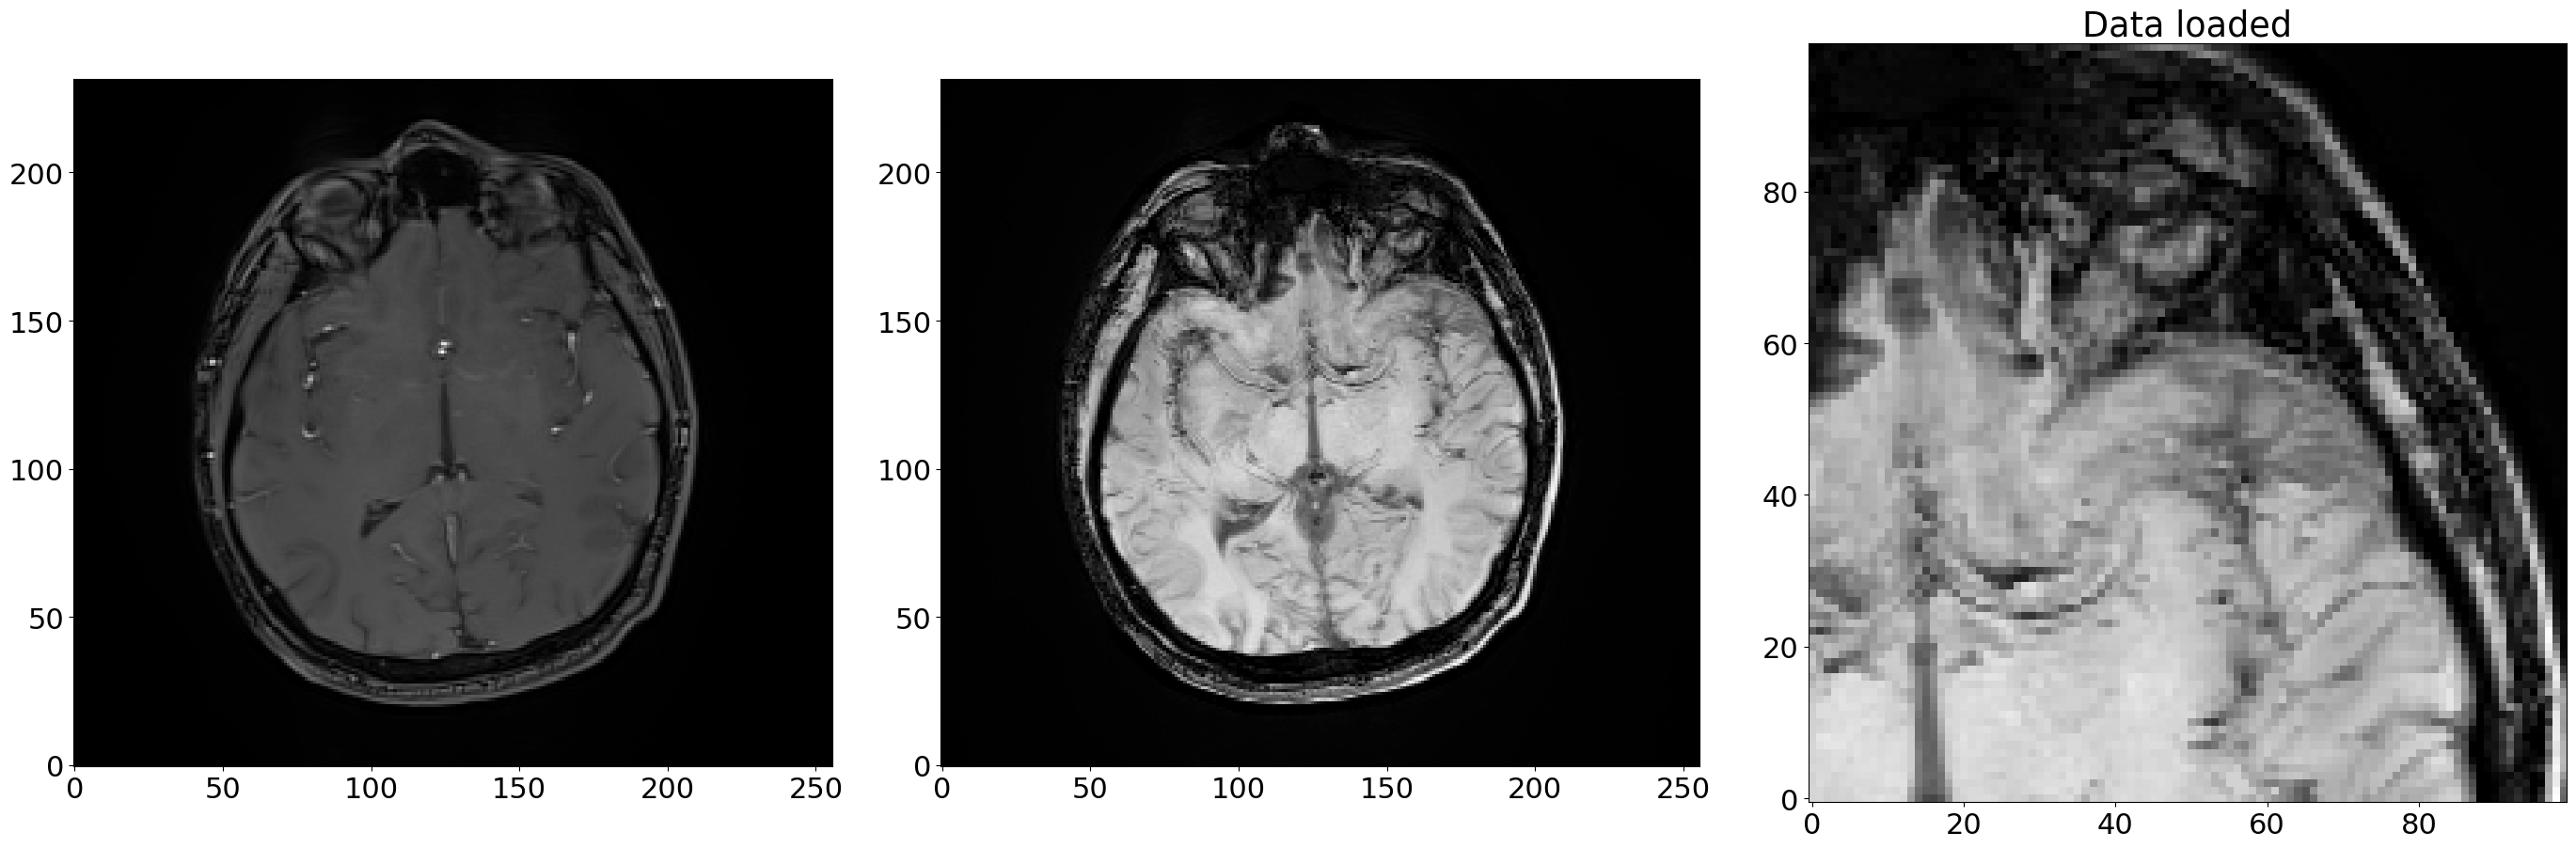

In [ ]:
# Load images and print them
mask_img   = image.load_img(input_mask_url)
mask       = mask_img.get_fdata()
input_img  = image.load_img(input_img_url)
voxel_size = mask_img.header.get_zooms()[0:2]

print("Voxel size is: ", voxel_size)
print("Image dim is: ", mask_img.shape)
#print("Image dim is: ", size)

if mip_dir == 'sag':
    sx, sy, sz  = MIP_half_thickness, window_half_size, window_half_size
    mip_axis = 0

    dx, ux = np.int(ix-sx), np.int(ix+sx)
    dy, uy = np.int(iy-sy), np.int(iy+sy)  
    dz, uz = np.int(iz-sz), np.int(iz+sz) 

    mip_cube = tuple([ slice(dx,ux,1), slice(dy,uy,1),   slice(dz,uz,1)    ])
    mip_view = tuple([ slice(dx,ux,1), slice(None,None), slice(None,None)  ])
    sng_cube = tuple([ ix,             slice(dy,uy,1),   slice(dz,uz,1)    ])
    sng_view = tuple([ ix,             slice(None,None), slice(None,None)  ])

elif mip_dir == 'cor':
    sx, sy, sz  = window_half_size, MIP_half_thickness, window_half_size
    mip_axis = 1

    dx, ux = np.int(ix-sx), np.int(ix+sx)
    dy, uy = np.int(iy-sy), np.int(iy+sy)  
    dz, uz = np.int(iz-sz), np.int(iz+sz) 

    mip_cube = tuple([ slice(dx,ux,1),   slice(dy,uy,1), slice(dz,uz,1)    ])
    mip_view = tuple([ slice(None,None), slice(dy,uy,1), slice(None,None)  ])
    sng_cube = tuple([ slice(dx,ux,1),   iy,             slice(dz,uz,1)    ])
    sng_view = tuple([ slice(None,None), iy,             slice(None,None)  ])

else :
    sx, sy, sz  = window_half_size, window_half_size, MIP_half_thickness
    mip_axis = 2

    dx, ux = np.int(ix-sx), np.int(ix+sx)
    dy, uy = np.int(iy-sy), np.int(iy+sy)  
    dz, uz = np.int(iz-sz), np.int(iz+sz)  

    mip_cube = tuple([ slice(dx,ux,1),    slice(dy,uy,1),    slice(dz,uz,1) ])
    mip_view = tuple([ slice(None, None), slice(None, None), slice(dz,uz,1) ])
    sng_cube = tuple([ slice(dx,ux,1),    slice(dy,uy,1),    iz             ])
    sng_view = tuple([ slice(None, None), slice(None, None), iz             ])
    
#Set-up window variables
print("Center: ",      ix, iy, iz)
print("Zoom window: ", sx, sy, sz)
print("Low limit: ",   dx, dy, dz)
print("High limit: ",  ux, uy, uz)
print("Size of single will be: ",        mask[sng_view].T.shape)
print("Size of zoomed single will be: ", mask[sng_cube].T.shape)
print("Size of MIP will be: ",           np.min(mask[mip_view], axis=mip_axis).shape)
print("Size of zoomed MIP will be: ",    np.min(mask[mip_cube], axis=mip_axis).shape)
   
#Plot the loaded images
fig, axes = plt.subplots(1, 3, figsize=(28, 20))
fig.tight_layout()
ax = axes.flatten()
ax[0].imshow(input_img.get_fdata()[sng_view].T, origin='lower', cmap=plt.cm.gray)
ax[1].imshow(np.min(input_img.get_fdata()[mip_view], axis=mip_axis).T, origin='lower', cmap=plt.cm.gray, alpha=1.0)
ax[2].imshow(np.min(input_img.get_fdata()[mip_cube], axis=mip_axis).T, origin='lower', cmap=plt.cm.gray, alpha=1.0)
plt.title("Data loaded")
plt.savefig("Loaded_data_fig.png", bbox_inches='tight')
plt.show()

#ax[0].imshow(np.min(input_img.get_fdata()[mip_view], axis=mip_axis).T, origin='lower', cmap=plt.cm.gray)
#ax[1].imshow(np.max(mask_img.get_fdata()[mip_view], axis=mip_axis).T, origin='lower', cmap=plt.cm.gray, alpha=1.0)
#ax[2].imshow(np.min(input_img.get_fdata()[mip_cube], axis=mip_axis).T, origin='lower', cmap=plt.cm.gray, alpha=1.0)
#plt.title("Data loaded")
#plt.savefig("Loaded_data_fig.png", bbox_inches='tight')
#plt.show()

### Functions

#### FUNCTION: Factor Analysis to combine scales
<pre>
Factor Analysis (FA)

A simple linear generative model with Gaussian latent variables.

The observations are of liner lower dimensional latent factors and added Gaussian noise.
Without loss of generality the factors are distributed according to a Gaussian with zero mean and unit covariance. 
The noise is also zero mean and has an arbitrary diagonal covariance matrix.

If we would restrict the model further, by assuming that the Gaussian noise is even isotropic, we get a PPCA.

Input: 
  - Image
  - Mask
  - sigma_min, sigma_max

Output:
  - Combined data matrix 
</pre>

In [ ]:
def FA_combine_scales(img_4D, mask, sigma_min, sigma_max):
    masker = NiftiMasker()
    data_masked = masker.fit_transform(img_4D)
    print(np.max(data_masked))
    assert np.max(data_masked) > 0, "Mask and data are not in same space/orient"

    
    p0, p99 = np.percentile(data_masked, (0, 99.8)) 
    data_masked = exposure.rescale_intensity(data_masked, in_range=(p0,p99))

    #print(data_masked.shape)

    print(np.max(data_masked))

    noise_variance_init=np.geomspace(sigma_min, sigma_max, data_masked.shape[0]) - sigma_min #[0:16]
    print("Noise variance: ", noise_variance_init)

    method = FactorAnalysis(n_components=1, 
                            noise_variance_init=noise_variance_init,
                            #noise_variance_init=np.geomspace(sigma_minimum, sigma_maximum, number_of_sigma_steps),
                            tol=0.005, max_iter=200)
    method.fit(data_masked.T)
    X_reduced = method.transform(data_masked.T)
    X_reduced[X_reduced<0] = 0
    #print(X_reduced.shape)

    #print(X_reduced.noise_variance_array_)
    fact_img = masker.inverse_transform(X_reduced.T)
    fact_img = image.index_img(fact_img,0)
    
    factimg=nilearn.image.math_img("np.where(x<0, 0, x)", x=fact_img)
    
    p0, p99 = np.percentile(factimg.get_fdata(), (0, 99.8)) 
    factdata = exposure.rescale_intensity(factimg.get_fdata(), in_range=(p0,p99))

    return factdata


#### FUNCTION: Skeletonize and diameters from mask
<pre>

Input: 
  - Vasculature thresholded
  - voxel size
  - upsampling factor (2 times minimum) -> precision is too bad lower than this

Output:
  - data arrays: skel, centerdia, distance, inverted_distance

Also generate those arrays as images on disk

</pre>

In [ ]:
def skeletonize_mask(i_thresh_img, i_voxel_size=0.6, i_factor=2.0):
    thresh_data = i_thresh_img.get_fdata()
    dil_thresh = binary_dilation(thresh_data)
    skel = morphology.skeletonize_3d(dil_thresh)
    #skel = image.load_img(outfold + output_prefix + "_VED_skel.nii.gz").get_fdata()
    skel[skel > 0] = 1.0

    prox_sampling = int(i_voxel_size/i_factor)

    #up_thresh = rescale(thresh_data, i_factor)
    #up_distance = ndi.distance_transform_edt(up_thresh, sampling=prox_sampling)
    #distance = resize(up_distance, skel.shape) * thresh_data
    distance = ndi.distance_transform_edt(thresh_data, sampling=i_voxel_size)
    centerdia = skel * distance

    #up_i_thresh = 1.0 - up_thresh
    up_i_thresh = 1.0 - thresh_data
    #up_i_distance = ndi.distance_transform_edt(up_i_thresh, sampling=prox_sampling) #get from header instead
    up_i_distance = ndi.distance_transform_edt(up_i_thresh, sampling=i_voxel_size) #get from header instead
    inverted_distance = up_i_distance  * up_i_thresh

    return skel, centerdia, distance, inverted_distance


#### FUNCTION: 3D OTSU automatic thresholding

<pre>
3D OTSU from 2D OTSU

Input: 
  - Data matrix to threshold
  - Offset [-1.0, 1.0]         (Positive = add vessels, Negative = remove vessels)

Output:
  - Thresholded Data 
</pre>

In [ ]:
def otsu_3D(i_img, offset=0.2):

    p0, p99 = np.percentile(i_img.get_fdata(), (0, 99.8)) 
    datacopy = exposure.rescale_intensity(i_img.get_fdata(), in_range=(p0,p99))

    #datacopy = fact_img.get_fdata()
    threshold_x = np.zeros_like(datacopy)
    threshold_y = np.zeros_like(datacopy)
    threshold_z = np.zeros_like(datacopy)

    offset = 0.2
    #threshold_local
    for x in range(datacopy.shape[0]):
        if np.max(datacopy[x, :, :]) == 0.0:
            val = 1.0
        else:
            img_adapteq = exposure.equalize_adapthist(datacopy[x,:,:], clip_limit=0.01)
            val = threshold_otsu(img_adapteq, nbins=400 )
            val = max(0.0, val-offset)
            threshold_x[x, :, :] = val

    for y in range(datacopy.shape[1]):
        if np.max(datacopy[:, y, :]) == 0.0:
            val = 1.0
        else:
            img_adapteq = exposure.equalize_adapthist(datacopy[:,y,:], clip_limit=0.01)
            val = threshold_otsu(img_adapteq, nbins=400 )
            val = max(0.0, val-offset)
            threshold_y[:, y, :] = val

    for z in range(datacopy.shape[2]):
        if np.max(datacopy[:, :, z]) == 0.0:
            val = 1.0
        else:
            img_adapteq = exposure.equalize_adapthist(datacopy[:,:,z], clip_limit=0.01)
            val = threshold_otsu(img_adapteq, nbins=400 )
            val = max(0.0, val-offset)
            threshold_z[:, :, z] = val

    threshold = np.stack((threshold_x, threshold_y, threshold_z), axis=3)
    threshold_min = np.min(threshold, axis=3)

    return datacopy > threshold_min


    


## Vasculature extraction

#### Run the "manual" multiscale method (new method)

In [ ]:
print("+-+-+- DOING MULTI-SCALE METHOD")

ImageType = type(in_image)
Dimension = in_image.GetImageDimension()  #would be 3

HessianPixelType = itk.SymmetricSecondRankTensor[itk.D, Dimension]
HessianImageType = itk.Image[HessianPixelType, Dimension]
print(HessianImageType)

objectness_filter = itk.HessianToObjectnessMeasureImageFilter[HessianImageType, ImageType].New()
objectness_filter.SetBrightObject(brightvessels)
objectness_filter.SetScaleObjectnessMeasure(scaleoutput)  #WAS FALSE per default
objectness_filter.SetAlpha(alpha) # 0.5 default
objectness_filter.SetBeta(beta)   # should be 1.0
objectness_filter.SetGamma(gamma) # was 5.0 in example, 300 at high gamma.. higher = less noise


outfold = out_folder + output_prefix + '_scales/'
if not os.path.exists(outfold):
    os.makedirs(outfold)


print("sigma_minimum is: " + str(sigma_minimum))
print("sigma_maximum is: " + str(sigma_maximum))
for step, sigma in enumerate(np.geomspace(sigma_minimum, sigma_maximum, number_of_sigma_steps)):

    scale_str = str(int(sigma*100000)).zfill(8)
    
    out_scale_prefix=outfold + output_prefix + "_" + scale_str

    if not os.path.exists(out_scale_prefix + "_VED.nii.gz"):
        print(" +-+- DOING sigma scale " + str(sigma) + ": " + str(step+1) + " of " + str(number_of_sigma_steps))
        multi_scale_filter = itk.MultiScaleHessianBasedMeasureImageFilter[ImageType, HessianImageType, ImageType].New()
        multi_scale_filter.SetInput(in_image)
        multi_scale_filter.SetHessianToMeasureFilter(objectness_filter)
        multi_scale_filter.SetSigmaStepMethodToLogarithmic()
        multi_scale_filter.SetSigmaMinimum(sigma)
        multi_scale_filter.SetSigmaMaximum(sigma)
        multi_scale_filter.SetNumberOfSigmaSteps(1)
        multi_scale_filter.SetGenerateHessianOutput(True)
        multi_scale_filter.Update()

        print("  +- ..write VED of sigma " + str(sigma) + ": " + str(step+1) + " of " + str(number_of_sigma_steps))
        Hessian_output=multi_scale_filter.GetHessianOutput()
        VED_output=multi_scale_filter.GetOutput()
        size=Hessian_output.GetBufferedRegion().GetSize()

        hessian_view = itk.GetArrayViewFromImage(Hessian_output)
        hessian_array = np.transpose(hessian_view, (2,1,0,3))
        ved_view = itk.GetArrayViewFromImage(VED_output)
        ved_array = np.transpose(ved_view, (2,1,0))
        ved_array = ved_array*mask

        #print(np.min(ved_array))
        #print(np.max(ved_array))
        p0, p99 = np.percentile(ved_array, (0, 99.8)) 
        ved_array = exposure.rescale_intensity(ved_array, in_range=(p0,p99))
        #print(np.min(ved_array))
        #print(np.max(ved_array))
    

        ved_img = nilearn.image.new_img_like(input_img, ved_array, copy_header=True)
        ved_img.to_filename(out_scale_prefix + "_VED.nii.gz")

        fig, axes = plt.subplots(1, 3, figsize=(28, 14))
        fig.tight_layout()
        ax = axes.flatten()
        ax[0].imshow(np.min(input_img.get_fdata()[mip_view], axis=mip_axis).T, origin='lower')
        ax[1].imshow(np.min(input_img.get_fdata()[mip_view], axis=mip_axis).T, origin='lower', cmap=plt.cm.gray, alpha=1.0)
        ax[1].imshow(np.max(     ved_array[mip_view], axis=mip_axis).T, origin='lower', cmap='viridis', alpha=0.7)
        ax[2].imshow(np.max(     ved_array[mip_view], axis=mip_axis).T, origin='lower')
        plt.title("VED for: " + str(sigma) + ": " + str(step+1) + " of " + str(number_of_sigma_steps))
        plt.savefig(out_scale_prefix + '_fig.png', bbox_inches='tight')
        plt.show()       
        
        
        fig, axes = plt.subplots(1, 3, figsize=(28, 14))
        fig.tight_layout()
        ax = axes.flatten()
        ax[0].imshow(np.min(input_img.get_fdata()[mip_cube], axis=mip_axis).T, origin='lower')
        ax[1].imshow(np.min(input_img.get_fdata()[mip_cube], axis=mip_axis).T, origin='lower', cmap=plt.cm.gray, alpha=1.0)
        ax[1].imshow(np.max(     ved_array[mip_cube], axis=mip_axis).T, origin='lower', cmap='viridis', alpha=0.7)
        ax[2].imshow(np.max(     ved_array[mip_cube], axis=mip_axis).T, origin='lower')
        plt.title("VED for: " + str(sigma) + ": " + str(step+1) + " of " + str(number_of_sigma_steps))
        plt.savefig(out_scale_prefix + '_ZOOM.png', bbox_inches='tight')
        plt.show()
        #plotting.plot_epi(ved_img, input_img, crop=True, filename=out_scale_prefix + "_VED.png", dpi=150)

        





+-+-+- DOING MULTI-SCALE METHOD
<class 'itk.itkImagePython.itkImageSSRTD33'>
sigma_minimum is: 1.0
sigma_maximum is: 1.95


## Postprocessing

### Combine the scales and automatic threshold

In [ ]:
print("+-+-+- Load VED images")
VED_images=nilearn.image.load_img(outfold + output_prefix + "*_VED.nii.gz", wildcards=True)
print("Shape is: ", VED_images.shape)

if not os.path.exists(outfold + output_prefix + "_VED_max.nii.gz"):
    print("+-+- Compute max image")
    max_VED_images=nilearn.image.math_img("np.max(a, axis=3)", a=VED_images)
    max_VED_images.to_filename(outfold + output_prefix + "_VED_max.nii.gz")
else:
    max_VED_images = image.load_img(outfold + output_prefix + "_VED_max.nii.gz")

if not os.path.exists(outfold + output_prefix + "_VED_FactorAnalysis.nii.gz"):
    print("+-+- Compute factory analysis")
    fact_data = FA_combine_scales(VED_images, mask_img, sigma_minimum, sigma_maximum)
    fact_img = image.new_img_like(input_img, fact_data)
    fact_img.to_filename(outfold + output_prefix + "_VED_FactorAnalysis.nii.gz") 
else:
    fact_img=image.load_img(outfold + output_prefix + "_VED_FactorAnalysis.nii.gz")
    
if fact_version:
    ved_img = fact_img
else:
    ved_img = max_VED_images

if not os.path.exists(outfold + output_prefix + "_VED_otsu_thresh.nii.gz"):
    print("+-+- Compute OTSU 3D analysis")
    thr_data = otsu_3D(ved_img, offset=otsu_offset)
    otsu_tresh_img = image.new_img_like(ved_img, thr_data)
    otsu_tresh_img.to_filename(outfold + output_prefix + "_VED_otsu_thresh.nii.gz")
else:
    otsu_tresh_img=image.load_img(outfold + output_prefix + "_VED_otsu_thresh.nii.gz")

if image_type == 0:
    if not os.path.exists(outfold + output_prefix + "_eroded2.nii.gz"):
        print("Eroding image...")
        otsu_path = outfold + output_prefix + "_VED_otsu_thresh.nii.gz"
        otsu_linux = "/mnt/" + otsu_path.lower().replace(":", "")
        #print(otsu_linux)
        mask_linux = "/mnt/" + input_mask_url.lower().replace(":","")
        #print(mask_linux)
        eroded_destination = outfold + output_prefix + "_eroded2.nii.gz"
        eroded_linux = "/mnt/" + eroded_destination.lower().replace(":", "")
        command_erode = ["wsl", "--shell-type", "login", "fslmaths", mask_linux]
        for i in range(2):
            command_erode.append("-ero")
        final_command_erode = command_erode + ["-mul", otsu_linux, eroded_linux]
        subprocess.run(final_command_erode, check=True)
        #subprocess.run(["wsl", "--shell-type", "login", "fslmaths", mask_linux, "-ero", "-ero", "-mul", otsu_linux, eroded_linux], check=True)

thresh_img = otsu_tresh_img
ved_data = fact_img.get_fdata()
thresh_data = otsu_tresh_img.get_fdata()



+-+-+- Load VED images
Shape is:  (256, 232, 136, 15)
Eroding image...


### Skeletonize and distance maps

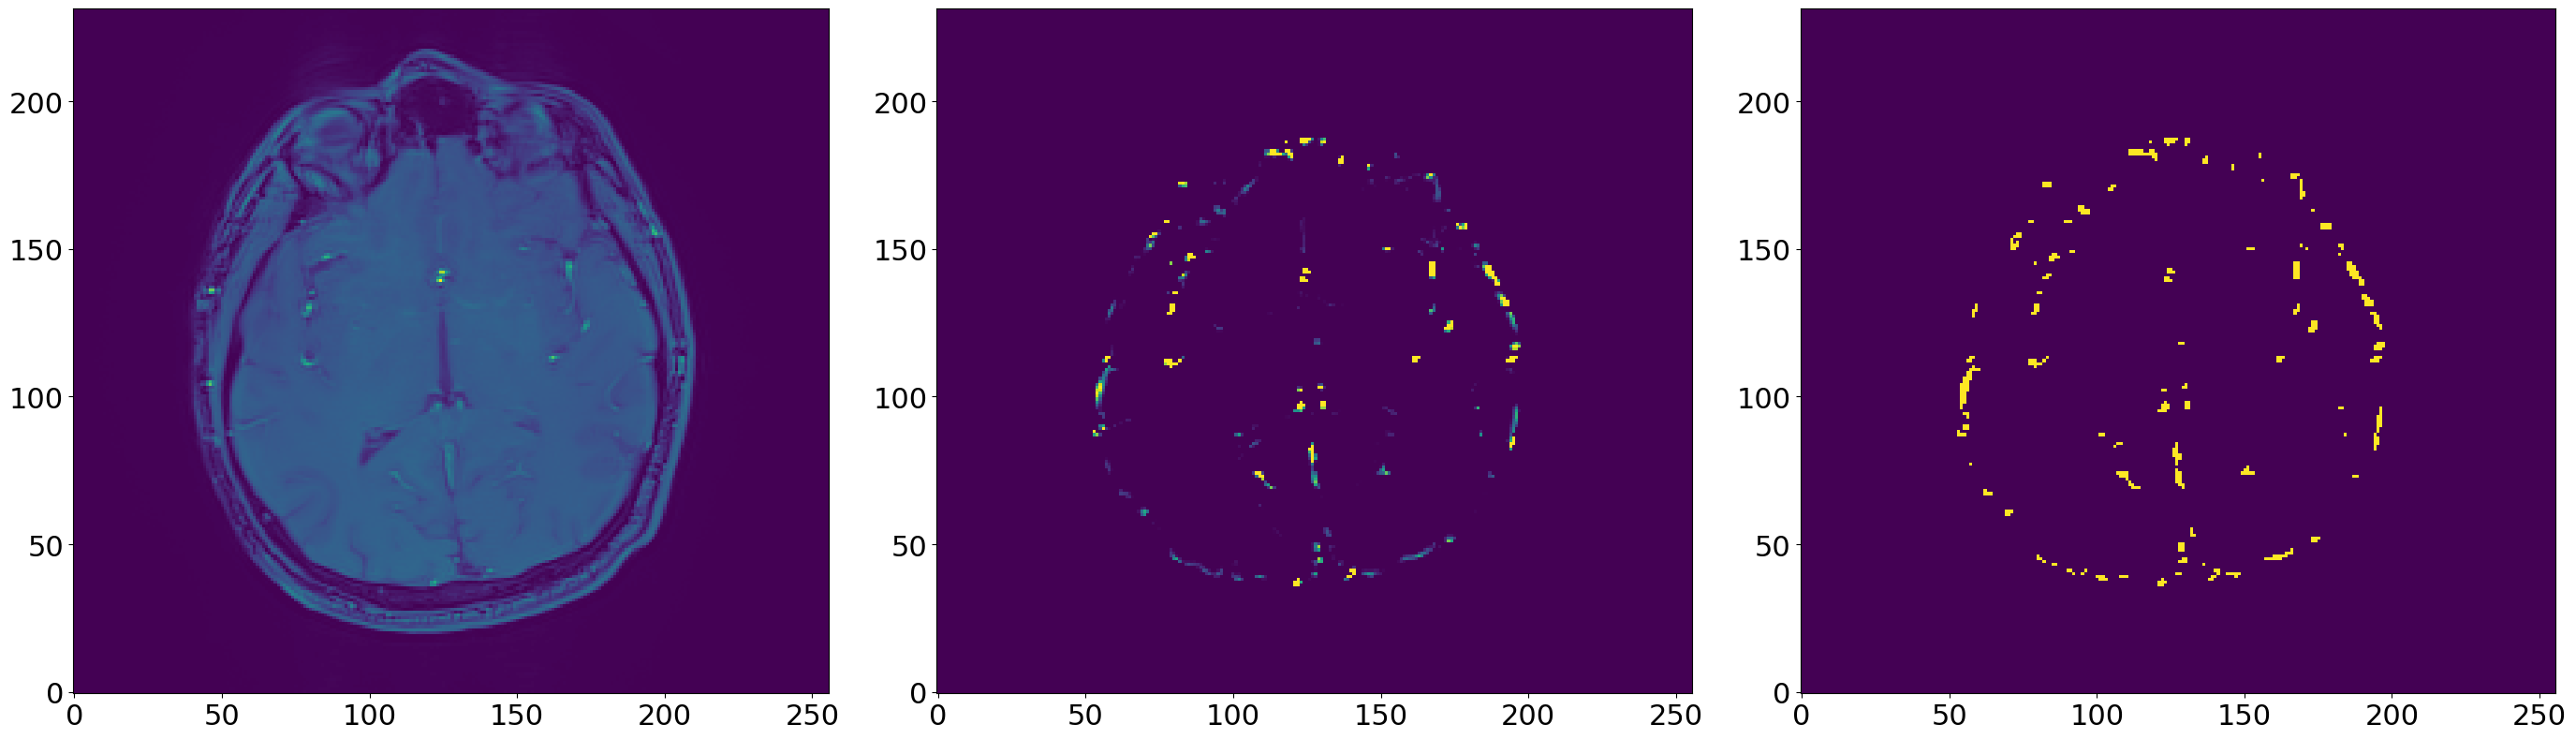

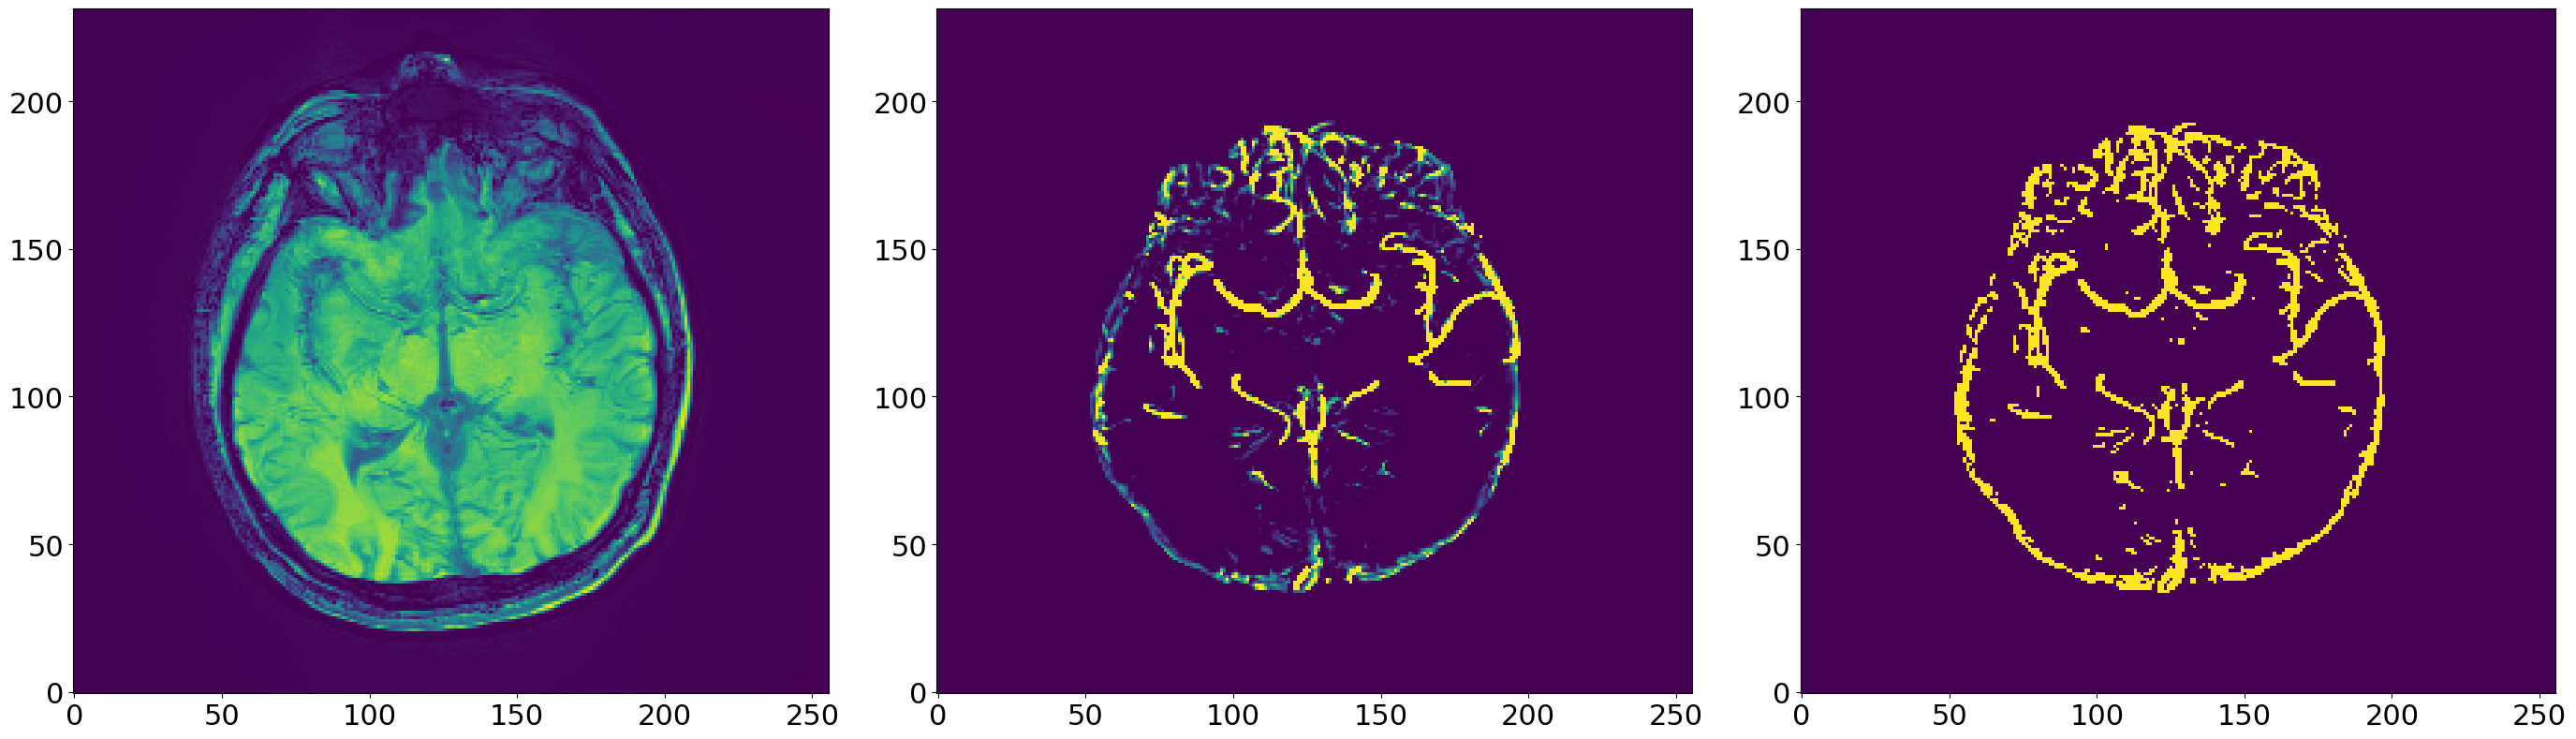

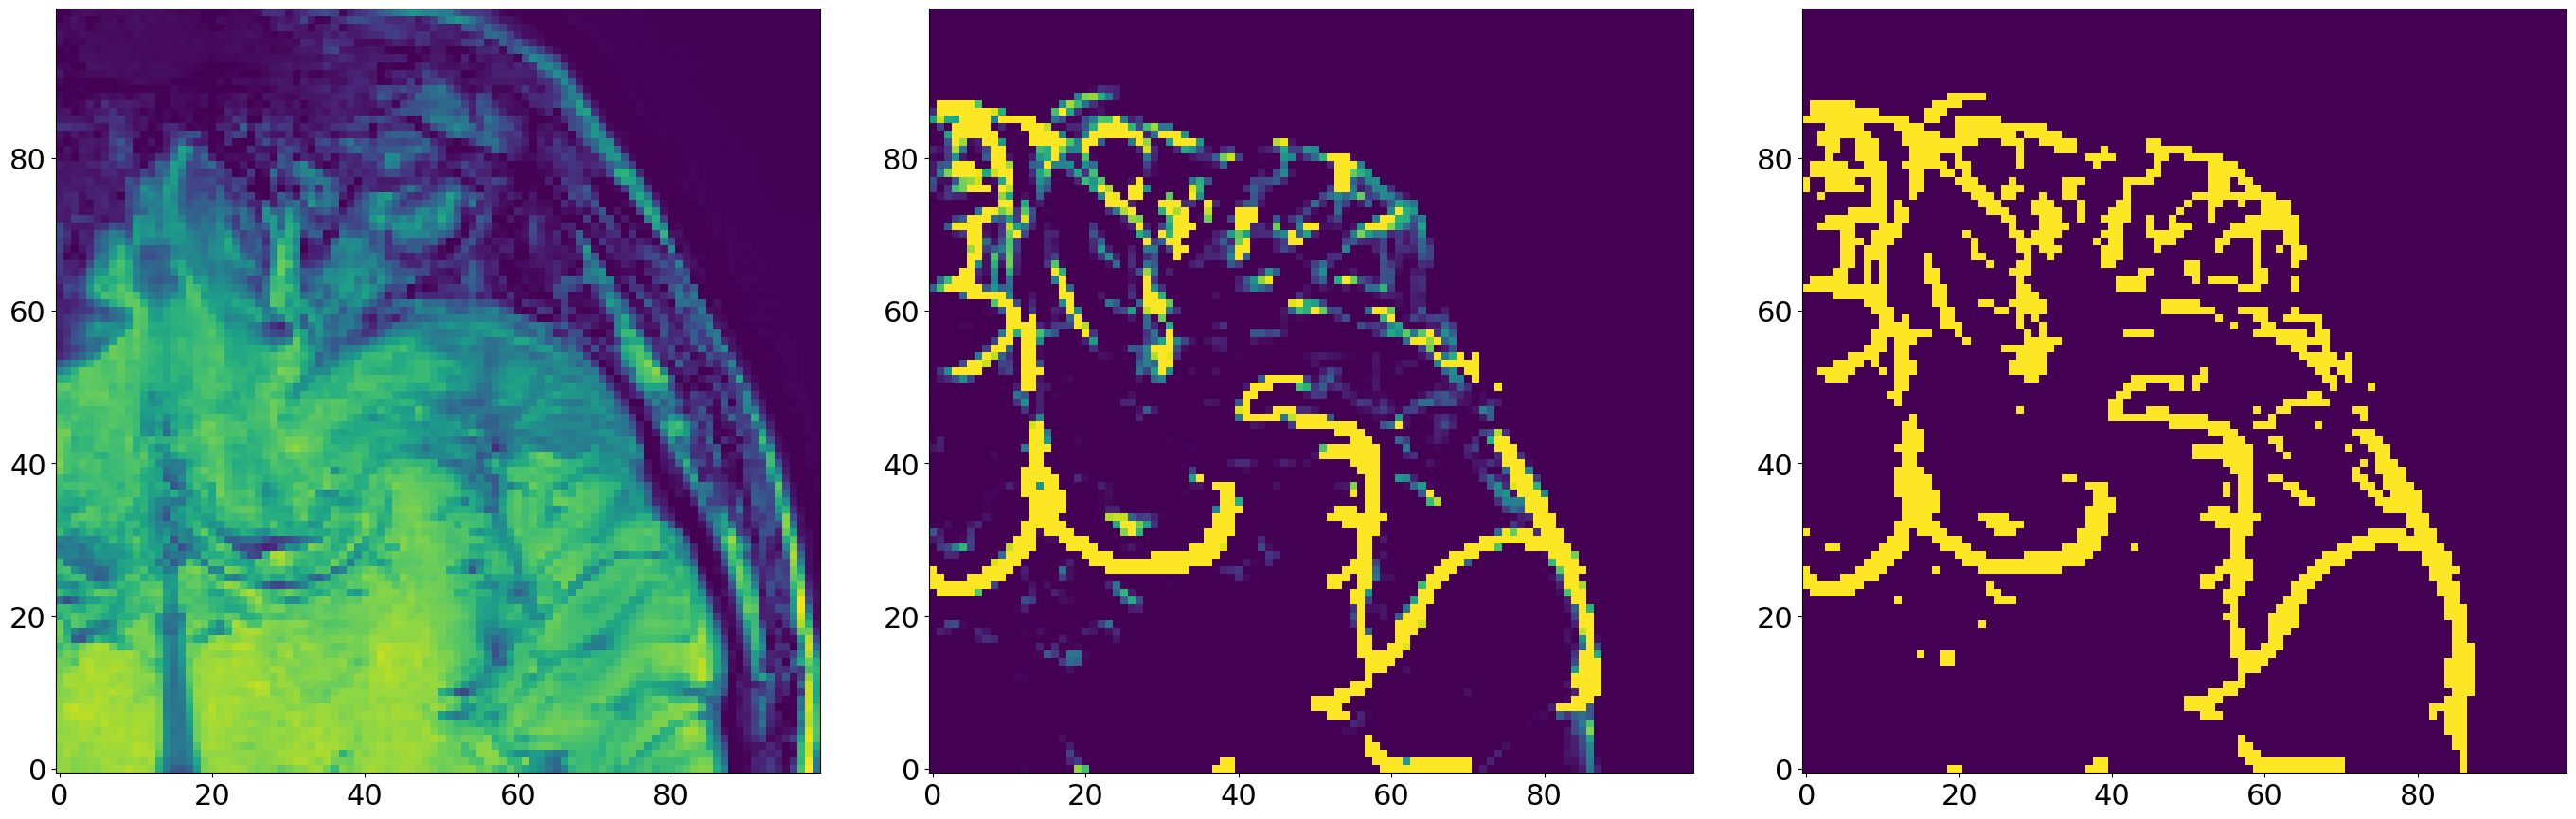

In [ ]:
#Print results

fig, axes = plt.subplots(1, 3, figsize=(28, 12))
fig.tight_layout()
ax = axes.flatten()
ax[0].imshow(input_img.get_fdata()[sng_view].T, origin='lower')
ax[1].imshow(ved_img.get_fdata()[sng_view].T, origin='lower', cmap='viridis')
ax[2].imshow(otsu_tresh_img.get_fdata()[sng_view].T, origin='lower', cmap='viridis')
plt.savefig(outfold + output_prefix + '_VED_processed.png', bbox_inches='tight')
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(28, 12))
fig.tight_layout()
ax = axes.flatten()
ax[0].imshow(np.min(input_img.get_fdata()[mip_view], axis=mip_axis).T, origin='lower')
ax[1].imshow(np.max(ved_img.get_fdata()[mip_view], axis=mip_axis).T, origin='lower', cmap='viridis')
ax[2].imshow(np.max(otsu_tresh_img.get_fdata()[mip_view], axis=mip_axis).T, origin='lower', cmap='viridis')
plt.savefig(outfold + output_prefix + '_VED_processed_MIP.png', bbox_inches='tight')
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(28, 12))
fig.tight_layout()
ax = axes.flatten()
ax[0].imshow(np.min(input_img.get_fdata()[mip_cube], axis=mip_axis).T, origin='lower')
ax[1].imshow(np.max(ved_img.get_fdata()[mip_cube], axis=mip_axis).T, origin='lower', cmap='viridis')
ax[2].imshow(np.max(otsu_tresh_img.get_fdata()[mip_cube], axis=mip_axis).T, origin='lower', cmap='viridis')
plt.savefig(outfold + output_prefix + '_VED_processed_MIP_ZOOM.png', bbox_inches='tight')
plt.show()

In [ ]:
if not os.path.exists(outfold + output_prefix + '_VED_inverted_distance.nii.gz') :  
    print("+-+-+- skeletonize and compute distance")        
    thresh_img = otsu_tresh_img
    skel, centerdia, distance, inverted_distance = \
        skeletonize_mask(thresh_img, i_voxel_size=np.min(voxel_size), i_factor=3.0)

    img = image.new_img_like(thresh_img, skel)
    img.to_filename(outfold + output_prefix + "_VED_skel.nii.gz")
    img = image.new_img_like(thresh_img, centerdia)
    img.to_filename(outfold + output_prefix + "_VED_centerdia.nii.gz")
    img = image.new_img_like(thresh_img, distance)
    img.to_filename(outfold + output_prefix + "_VED_distance.nii.gz")
    img = image.new_img_like(thresh_img, inverted_distance)
    img.to_filename(outfold + output_prefix + "_VED_inverted_distance.nii.gz")
else :
    skel =              image.load_img(outfold + output_prefix + "_VED_skel.nii.gz").get_fdata()
    centerdia =         image.load_img(outfold + output_prefix + "_VED_centerdia.nii.gz").get_fdata()
    distance =          image.load_img(outfold + output_prefix + "_VED_distance.nii.gz").get_fdata()
    inverted_distance = image.load_img(outfold + output_prefix + "_VED_inverted_distance.nii.gz").get_fdata()

In [ ]:
#print results
fig, axes = plt.subplots(1, 4, figsize=(25, 12))
ax = axes.flatten()
ax[0].imshow(np.max(ved_img.get_fdata()[mip_view], axis=mip_axis).T, origin='lower', cmap="gray")
ax[0].imshow(np.max(skel[mip_view], axis=mip_axis).T, origin='lower', cmap='viridis', alpha=0.5)
ax[1].imshow(np.max(centerdia[mip_view], axis=mip_axis).T, origin='lower', cmap="viridis")
ax[2].imshow(np.mean(distance[mip_view], axis=mip_axis).T, origin='lower', cmap="viridis")
ax[3].imshow(np.max(skel[mip_view], axis=mip_axis).T, origin='lower', cmap="gray")
ax[3].imshow(np.mean(inverted_distance[mip_view], axis=mip_axis).T, origin='lower', cmap="viridis", alpha=0.85)
fig.savefig(outfold + output_prefix + '_skeletonized.png', bbox_inches='tight')
fig.show()

fig, axes = plt.subplots(1, 4, figsize=(25, 12))
ax = axes.flatten()
ax[0].imshow(np.max(ved_img.get_fdata()[mip_cube], axis=mip_axis).T, origin='lower', cmap="gray")
ax[0].imshow(np.max(skel[mip_cube], axis=mip_axis).T, origin='lower', cmap='viridis', alpha=0.5)
ax[1].imshow(np.max(centerdia[mip_cube], axis=mip_axis).T, origin='lower', cmap="gray")
ax[2].imshow(np.mean(distance[mip_cube], axis=mip_axis).T, origin='lower', cmap="viridis")
ax[3].imshow(np.max(skel[mip_cube], axis=mip_axis).T, origin='lower', cmap="gray")
ax[3].imshow(np.mean(inverted_distance[mip_cube], axis=mip_axis).T, origin='lower', cmap="viridis", alpha=0.85)
fig.savefig(outfold + output_prefix + '_skeletonized_zoom.png', bbox_inches='tight')
fig.show()